In [679]:
import numpy as np
import pandas as pd
import altair as alt
from statsmodels.tsa.api import Holt
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing


class Parameters:
    def __init__(self, tau, init_infected, fi, theta, countries, critical_condition_rate, recovery_rate,
            critical_condition_time, recovery_time):
        self.tau = tau
        self.init_infected = init_infected
        self.fi = fi  # proportion of infectives are never diagnosed
        self.theta = theta  # diagnosis daily rate

        self.countries = countries
        self.critical_condition_rate = critical_condition_rate
        self.recovery_rate = recovery_rate
        self.critical_condition_time = critical_condition_time
        self.recovery_time = recovery_time


class OLG:
    """
    calc_asymptomatic start from first case
    exposed are the asymptomatic_infected with lag not only infected
    asymptomatic_infected eq 10 does not always grow but uses two diferent R0

    fi  # proportion of infectives are never diagnosed
    theta = theta  # diagnosis daily rate

    """

    def __init__(self, df, p: Parameters, jh_hubei,
                 stringency, have_serious_data=True):
        self.detected = []
        self.r_adj = np.array([])
        self.r_values = np.array([])
        self.r_valhubei = np.array([])
        self.r_schina = np.array([])
        self.r0d = np.array([])
        self.asymptomatic_infected = []
        self.df = pd.DataFrame()
        self.df_tmp = pd.DataFrame()
        self.tmp = None
        self.have_serious_data = have_serious_data
        self.r_hubei = None
        self.r_predicted = []
        self.day_0 = None

        self.iter_countries(df, p, jh_hubei, stringency)

    @staticmethod
    def next_gen(r0, tau, c0, ct):
        r0d = r0 / tau
        return r0d * (ct - c0) + ct

    @staticmethod
    def true_a(fi, theta, d, d_prev, d_delta_ma):
        prev_asymptomatic_infected = (
            1 / (1 - fi)) * (d_delta_ma / theta + d_prev)
        return prev_asymptomatic_infected

    @staticmethod
    def crystal_ball_regression(hubei):
        
#        crystal_ball_coef = {'intercept':0.4760240,
#                              'hubei': 0.270337,
#                             }
#
#        ln_r = crystal_ball_coef.get('intercept')   \
#               + crystal_ball_coef.get('hubei') * hubei      
        ln_r = hubei       
        return np.exp(hubei)

    def iter_countries(self, df, p, jh_hubei, stringency):

        self.process(init_infected=p.init_infected, detected=jh_hubei)
        self.calc_r(tau=p.tau, init_infected=p.init_infected)
        self.r_hubei = self.r_adj
        self.r_valhubei = self.r_values
        for country in p.countries:
            self.df_tmp = df[df['country'] == country].copy()
            self.process(init_infected=p.init_infected)
            self.calc_r(tau=p.tau, init_infected=p.init_infected)
            if country == 'israel':
                self.predict(country, p.tau, stringency)
                self.predict_next_gen(tau=p.tau)
            self.calc_asymptomatic(
                       fi=p.fi,
                       theta=p.theta,
                       init_infected=p.init_infected)
            self.write(stringency, tau=p.tau, critical_condition_rate=p.critical_condition_rate,
                       recovery_rate=p.recovery_rate, critical_condition_time=p.critical_condition_time,
                       recovery_time=p.recovery_time)

    def process(self, init_infected, detected=None):
        if detected is None:
            detected = self.df_tmp['total_cases'].values

        day_0 = np.argmax(detected >= init_infected)
        self.day_0 = day_0
        detected = detected[day_0:]
        self.detected = [detected[0]]
        for t in range(1, len(detected)):
            self.detected.append(max(detected[t - 1] + 1, detected[t]))

        if not self.df_tmp.empty:
            self.df_tmp = self.df_tmp[day_0:]
            self.df_tmp['StringencyIndex'].fillna(method='ffill', inplace=True)

    def calc_r(self, tau, init_infected):
        epsilon = 1e-06
        detected = self.detected
        r_values = np.array(
            [(detected[0] / (init_infected + epsilon) - 1) * tau])
        for t in range(1, len(detected)):
            if t <= tau:  # Ephraim
                r_value = (detected[t] - detected[t - 1]) / \
                           (detected[t - 1]) * tau
            elif t > tau:
                r_value = (detected[t] - detected[t - 1]) / \
                           (detected[t - 1] - detected[t - tau]) * tau
            r_values = np.append(r_values, max(r_value, 0))
        r_values = np.nan_to_num(r_values,nan=0.001,posinf=0.001,neginf=0.001)
        r_values = np.clip(r_values, 0.001, 15) 
        r_st = []
        for i in np.arange(len(r_values)):
            aleft = r_values[np.max([0, i - 2]):i] 
            aright = r_values[(i+1 ):(i +3)] 
            conc = np.concatenate((aleft, aright))
            tmpmean = np.mean(conc)
            score = abs(r_values[i]/tmpmean)
            if (score > 2.0 and r_values[i] > np.max(conc)): 
                r_st = np.append(r_st, tmpmean)
            else:
                r_st = np.append(r_st, r_values[i])        
        double_model = ExponentialSmoothing( r_st, trend='add').fit(smoothing_level=0.20)
        ysmooth = double_model.fittedvalues 
        ysmooth[ysmooth<=0] = 0.0000001
        print('ysmooth',ysmooth)
        r_adj = ysmooth           


        plt.rcParams["figure.figsize"] = (20,20)
        plt.plot(r_adj, marker="o", color='blue')
        #plt.plot(r_st, marker="+", color='red')
        
        plt.plot(r_values, marker="+", color='green')
        plt.show()
        # plt.plot(double_model.fittedvalues[1],marker="x", color='red')
        self.r_values, self.r_adj, self.r0d = r_values, r_adj, r_adj


    def predict(self, country, tau, scenario_stringency):
        forcast_cnt=len(scenario_stringency)
        if country == 'israel':
            # pad hubei data for israel forcast
            r_hubei=self.r_hubei
            if 0 < forcast_cnt + len(self.r0d) - len(r_hubei):
                r_hubei=r_hubei.append(
                    r_hubei[-1] * (forcast_cnt - len(r_hubei)))

            # normalize to day_0 and then shift forward 7 days so dont need to
            # lag in regression
            cur_stringency=self.df_tmp['StringencyIndex'].fillna(method = 'ffill').values.copy()
                
            scenario_stringency=scenario_stringency['StringencyIndex'].values

            stringency=np.append(cur_stringency, scenario_stringency)
            last_stringency=len(stringency) - 1
            self.r_predicted=[None] * 6
            for t in range(6, len(self.r0d) + forcast_cnt):
                projected_r=self.crystal_ball_regression(np.log(r_hubei[t]))
                                                             
                if t >= len(self.r0d):
                    self.r0d=np.append(self.r0d, projected_r)

                self.r_predicted=np.append(self.r_predicted, projected_r)
        else:
            holt_model = Holt(self.r_adj[-tau:], exponential = True).fit(smoothing_level = 0.1, smoothing_slope =0.9)
            self.r0d=np.append(
    self.r_adj, holt_model.forecast(
        forcast_cnt + 1))
        self.r0d=np.clip(self.r0d, 0, 100)

    def predict_next_gen(self, tau):
        t=len(self.detected)
        next_gen=self.detected[-1]
        c0=self.detected[t - tau] if t - tau >= 0 else 0

        while t <= len(self.r0d) - 1:
            next_gen = self.next_gen(r0 = self.r0d[t], tau = tau, c0 =c0, ct=next_gen)
            self.detected.append(next_gen)
            t += 1

    def calc_asymptomatic(self, fi, theta, init_infected):
        detected_deltas=[self.detected[0]]

        for i in range(1, len(self.detected)):
            delta=self.detected[i] - self.detected[i - 1]
            detected_deltas.append(delta)

        detected_deltas_ma=np.convolve(detected_deltas, np.ones(
            int(4, )) / int(4), mode = 'full')[:len(detected_deltas)]

        asymptomatic_infected = [ self.true_a(fi = fi, theta = theta, d =self.detected[0], d_prev=init_infected, d_delta_ma=detected_deltas_ma[0])]


        for t in range(1, len(self.detected)):
            prev_asymptomatic_infected = self.true_a(fi = fi, theta = theta, d =self.detected[t],d_prev=self.detected[t - 1], d_delta_ma=detected_deltas_ma[i])

            asymptomatic_infected.append(prev_asymptomatic_infected)
        self.asymptomatic_infected=asymptomatic_infected

    def calc_critical_condition(
        self, df, critical_condition_time, recovery_time, critical_condition_rate):
        # calc critical rate
        df['true_critical_rate']=df['serious_critical'] / (df['total_cases'].shift(
            critical_condition_time) - df['total_cases'].shift(critical_condition_time + recovery_time))


        critical_rates=df['serious_critical'] / (
                df['total_cases'].shift(critical_condition_time) - df['total_cases'].shift(
            critical_condition_time + recovery_time))
        last_critical_rate=critical_rates.dropna().iloc[-7:].mean()

        # critical condition - currently using parameter
        df['Critical_condition']=(df['total_cases'].shift(critical_condition_time) - df['total_cases'].shift( critical_condition_time + recovery_time + 1)) * critical_condition_rate
            

        
        return df['Critical_condition']
    
    def write(self, stringency, tau, critical_condition_rate, recovery_rate, critical_condition_time, recovery_time):
        if self.have_serious_data == False:
            self.df_tmp['serious_critical'] = None
            self.df_tmp['new_cases'] = self.df_tmp['total_cases'] - self.df_tmp['total_cases'].shift(1)
            self.df_tmp['activecases'] = None
            self.df_tmp['total_deaths'] = None
            self.df_tmp['new_deaths'] = None
        
        df = self.df_tmp[
                  ['date', 'country', 'StringencyIndex', 'serious_critical', 'new_cases', 'activecases', 'new_deaths',
                  'total_deaths']].reset_index(drop=True).copy()  
       
        df['r_values'] = self.r_values
        df['r_adj'] = self.r_adj
        
        # pad df for predictions
        forcast_cnt = len(self.detected) - len(self.r_adj)
        if forcast_cnt > 0:
            predict_date = df['date'].max() + pd.to_timedelta(1, unit="D")
            prediction_dates = pd.date_range(start=predict_date.strftime('%Y-%m-%d'), periods=forcast_cnt)
            predicted = pd.DataFrame({'date': prediction_dates})
            predicted.loc[:forcast_cnt, 'StringencyIndex'] = stringency['StringencyIndex'].values
            df = df.append(predicted, ignore_index=True)        
        df['total_cases'] = self.detected
        df['R'] = self.r0d     
        df['infected'] = self.asymptomatic_infected
        df['exposed'] = df['infected'].shift(periods=-tau)
        df['country'].fillna(method='ffill', inplace=True)
        df['corona_days'] = pd.Series(range(1, len(df) + 1))
        df['prediction_ind'] = np.where(df['corona_days'] <= len(self.r_adj), 0, 1)
        df['Currently Infected'] = np.where(df['corona_days'] <= (critical_condition_time + recovery_time),df['total_cases'], df['total_cases'] - df['total_cases'].shift(periods=(critical_condition_time + 6 + recovery_time)))
        df['Doubling Time'] = np.log(2) / np.log(1 + df['R'] / tau)
        
        df['dI'] = df['total_cases'] - df['total_cases'].shift(1)
        df['dA'] = df['infected'] - df['infected'].shift(1)
        df['dE'] = df['exposed'] - df['exposed'].shift(1)
        
        df['Critical_condition'] = self.calc_critical_condition(df, critical_condition_time, recovery_time,
                                                                critical_condition_rate)
        df['Recovery_Critical'] = df['dI'].shift(recovery_time + critical_condition_time) * critical_condition_rate * recovery_rate
                
        df['Mortality_Critical'] = df['dI'].shift(recovery_time + critical_condition_time) * critical_condition_rate * ( 1 - recovery_rate)
               
        df['Recovery_Critical'] = df['Recovery_Critical'].apply(lambda x: max(x, 0)).fillna(0).astype(int)
        df['Mortality_Critical'] = df['Mortality_Critical'].apply(lambda x: max(x, 0)).fillna(0).astype(int)
        
        df['Total_Mortality'] = df['Mortality_Critical'].cumsum()
        df['Total_Critical_Recovery'] = df['Recovery_Critical'].cumsum()
        
        # fill with obsereved values
        
        df[['Critical_condition', 'Currently Infected', 'total_cases', 'exposed', 'Recovery_Critical',
            'Mortality_Critical']] = df[['Critical_condition', 
            'Currently Infected', 'total_cases', 'exposed', 'Recovery_Critical',
            'Mortality_Critical']].round(0)
        if self.have_serious_data:
            df = df.rename(columns={'total_cases': 'Total Detected',
                                    'infected': 'Total Infected Predicted',
                                    'exposed': 'Total Exposed Predicted',
                                    'Total_Mortality': 'Total Deaths Predicted',
                                    'total_deaths': 'Total Deaths Actual',
                                    'dI': 'New Detected Predicted',
                                    'new_cases': 'New Detected Actual',
                                    'dA': 'New Infected Predicted',
                                    'dE': 'New Exposed Predicted',
                                    'Mortality_Critical': 'Daily Deaths Predicted',
                                    'new_deaths': 'Daily Deaths Actual',
                                    'Critical_condition': 'Daily Critical Predicted',
                                    'serious_critical': 'Daily Critical Actual',
                                    'Recovery_Critical': 'Daily Recovery Predicted',
                                    'Currently Infected': 'Currently Active Detected Predicted',
                                    'activecases': 'Currently Active Detected Actual',
                                    'true_critical_rate': 'Daily Critical Rate Actual',
                                    'r_hubei': 'R China-Hubei Actual',
                                    'r_predicted': 'R Predicted'
                                    })
        
        df['r_hubei'] = self.r_hubei[:df.shape[0]]
        df['r_valhubei'] = self.r_valhubei[:df.shape[0]]
        df['r_valhubei'].fillna(0)
        df['r_valhubei'] = df['r_valhubei'].replace([np.inf, -np.inf], 0)
        df['Doubling Time'] = df['Doubling Time'].replace([np.inf, -np.inf], 0)
        if df.loc[0, 'country'] == 'israel':
            df.loc[:, 'r_predicted'] = self.r_predicted[:df.shape[0]]
        self.df = pd.concat([self.df, df])


def plot_data(df, countries, var_in_multi_line='Total Detected'):
    country_count = df['country'].nunique()
    
    if country_count == len(countries):
        plot_df = df.query('prediction_ind==0').melt(id_vars=['corona_days'], value_vars=var_in_multi_line)
        plot_df_predict = df.query('prediction_ind==1').melt(id_vars=['corona_days'], value_vars=var_in_multi_line)
    
    else:
        plot_df = df.query('prediction_ind==0').pivot(index='corona_days', columns='Country',values=var_in_multi_line).reset_index().melt(id_vars=['corona_days'],value_vars=countries)
                              
                               
        plot_df_predict = df.query('prediction_ind==1').pivot(index='corona_days', columns='Country', values=var_in_multi_line).reset_index().melt(id_vars=['corona_days'],value_vars=countries)
   
    plot_df.dropna(inplace=True)
    plot_df_predict.dropna(inplace=True)
    plot_df['value'] = plot_df['value']
    plot_df_predict['value'] = plot_df_predict['value']
    
    color_group = 'variable' if country_count == 1 else 'country'
    
    # The basic line
    line = alt.Chart(plot_df).mark_line(interpolate='basis').encode(
        x='corona_days:Q',
        y='value',
        color=color_group
    )
    
    line2 = alt.Chart(plot_df_predict).mark_line(interpolate='basis', strokeDash=[1, 1]).encode(
        x='corona_days:Q',
        y='value',
        color=color_group
    )
    return alt.layer(
        line, line2
    ).properties(
        width=600, height=300
    )


from scipy.io import loadmat

mat = loadmat('sample.mat')
jh_hubei_list = mat.get('hubei')[0]
# jh_israel_list = mat.get('israel')[0]
# jh_hubei_list = ([0]*(len(jh_hubei_list) - len(jh_israel_list))).append(jh_israel_list)

In [680]:
import numpy as np
import pandas as pd
#from OLG_model_src import  OLG, Parameters,plot_data
import altair as alt


#%load_ext autoreload
#%autoreload 2

In [681]:
path = '/Users/ephraimgoldin/Dropbox/OLG Model 2/'

jh_hubei_data = pd.read_csv(path + 'jh_hubei_data.csv').values 
#countrydata_df = pd.read_csv(path + 'countries_data.csv', parse_dates=['date'])
countrydata_df = pd.read_csv('https://raw.githubusercontent.com/gstat-gcloud/covid19-sim/master/Resources/Datasets/CountryData/all_dates.csv',
                             parse_dates=['date'])
stringency = pd.read_csv(path + 'stringencyExample.csv', usecols=['date', 'StringencyIndex'], parse_dates=['date'])
#from scipy.io import loadmat
#mat = loadmat(path +'sample.mat')


In [682]:
p = Parameters(tau=8,
               init_infected=50,
               fi=0.25,
               theta=0.0771,
               countries=['israel'],
               critical_condition_rate=0.051,
               recovery_rate=0.4,
               critical_condition_time=10,
               recovery_time=6
               )


/Users/ephraimgoldin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: divide by zero encountered in true_divide
/Users/ephraimgoldin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
/Users/ephraimgoldin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


ysmooth [3.37424644e+00 4.33562339e+00 5.34090005e+00 6.49197023e+00
 6.83314757e+00 6.99761203e+00 6.58033689e+00 5.69322763e+00
 5.20092663e+00 4.96653693e+00 4.85351307e+00 4.64133717e+00
 4.24147970e+00 3.22369975e+00 3.11196278e+00 2.59372262e+00
 2.24325126e+00 1.91983755e+00 1.64870732e+00 1.49589539e+00
 1.33344194e+00 1.07761925e+00 9.03796176e-01 6.79739317e-01
 5.37513936e-01 4.17392164e-01 2.95527871e-01 4.25027793e-02
 2.55132136e-02 3.10989009e-01 2.66908662e-01 2.48172955e-01
 2.38671630e-01 2.35278586e-01 1.50967962e-01 8.52904485e-02
 3.60664065e-02 1.30559449e-03 1.00000000e-07 1.00000000e-07
 1.62201864e-01 3.69361255e-01 5.62434580e-01 6.80627531e-01
 8.36379528e-01 8.83008851e-01 8.82010032e-01 8.12530988e-01
 7.50500606e-01 7.15111316e-01 6.87611035e-01 6.14971111e-01
 5.20932643e-01 4.61904142e-01 3.75205175e-01 2.94304645e-01
 2.14336259e-01 1.43239347e-01 9.48230467e-02 8.12428778e-02
 1.03791986e-01 7.90254659e-02 7.61910911e-02 5.10052717e-02
 1.14272677e-02 

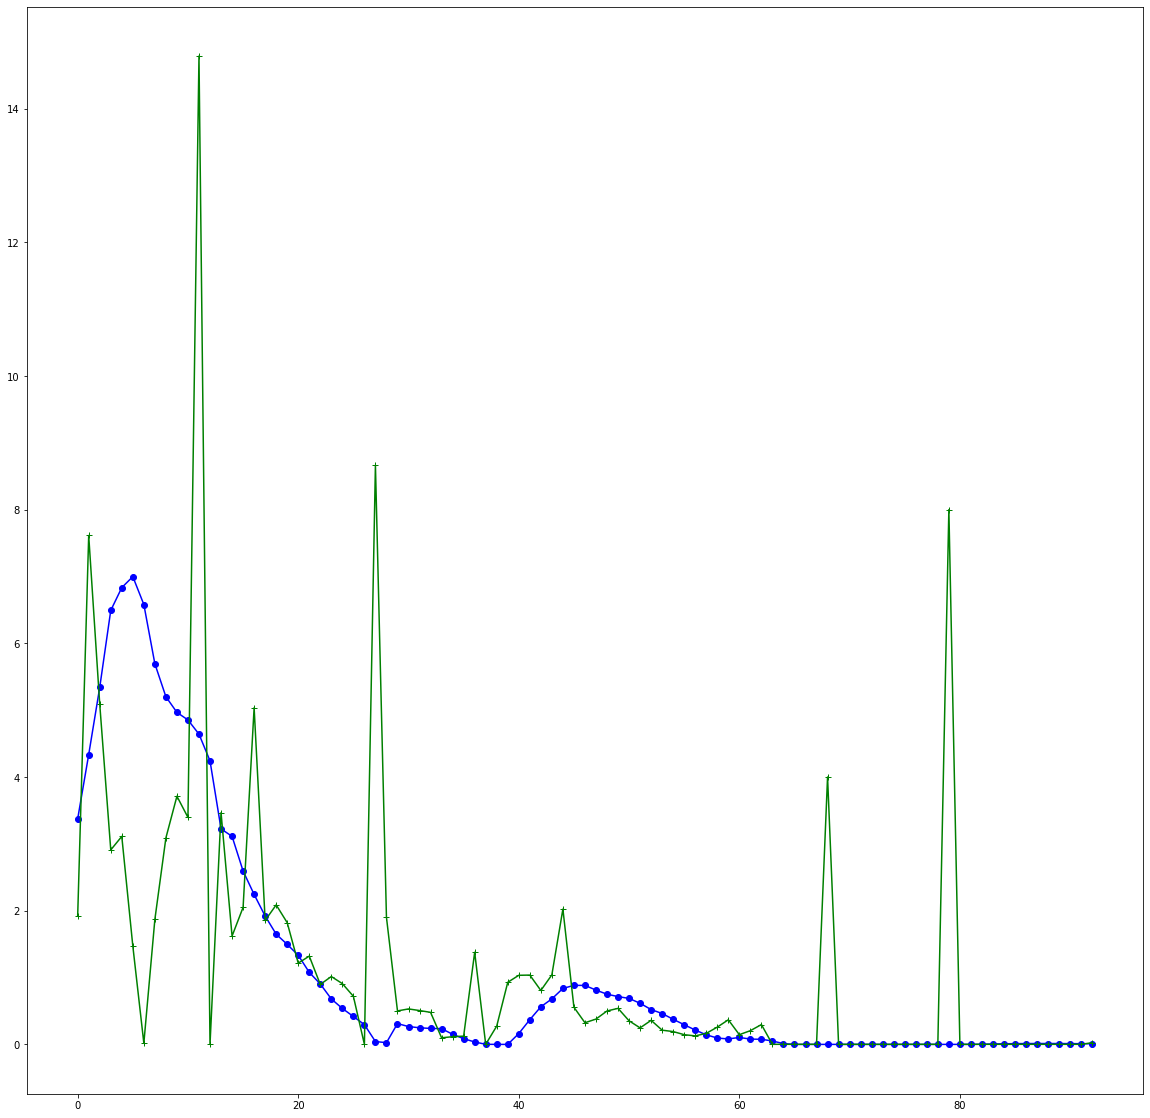

/Users/ephraimgoldin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


ysmooth [1.22335264 1.97767458 2.76881497 3.63168479 3.94490945 4.13920803
 4.255075   4.06358913 4.34825218 4.01483474 3.79901085 3.21633896
 3.11773051 2.91311338 3.04683489 3.11823243 2.93177986 2.54109854
 2.1975074  2.04454194 1.88005991 1.57685273 1.43683888 1.35236339
 1.28261817 1.1100357  0.89304031 0.79234312 0.67875423 0.53634858
 0.34720046 0.44478449 0.50414815 0.52101772 0.60069402 0.72986708
 0.87342691 0.99113803 0.94480441 0.89132265 0.77766637 0.88981204
 0.86572578 0.86713479 0.89157874 0.97682375 1.00099343]


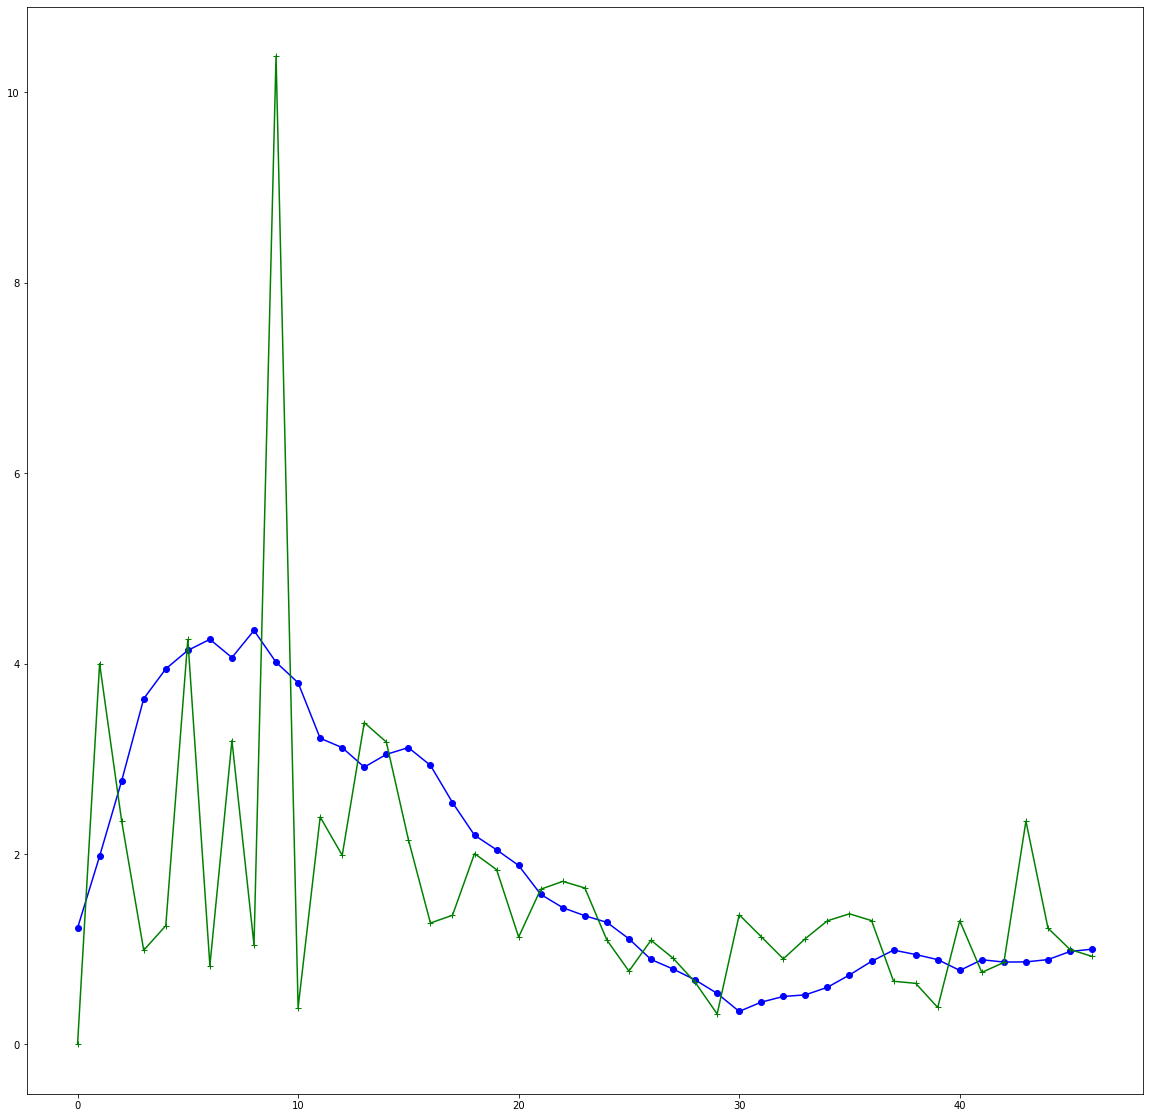

In [683]:
olg_model = OLG(countrydata_df, p, jh_hubei_data, stringency) # please note stringency file 

olg_model.df.to_excel('olg_results.xlsx', index=False)

In [668]:
yhat

NameError: name 'yhat' is not defined

In [588]:
jh_hubei_data

array([[   41],
       [   41],
       [   41],
       [   41],
       [   41],
       [   45],
       [   62],
       [  121],
       [  198],
       [  270],
       [  375],
       [  444],
       [  444],
       [  549],
       [  761],
       [ 1058],
       [ 1423],
       [ 3554],
       [ 3554],
       [ 4903],
       [ 5806],
       [ 7153],
       [11177],
       [13522],
       [16678],
       [19665],
       [22112],
       [24953],
       [27100],
       [29631],
       [31728],
       [33366],
       [33366],
       [48206],
       [54406],
       [56249],
       [58182],
       [59989],
       [61682],
       [62031],
       [62442],
       [62662],
       [64084],
       [64084],
       [64287],
       [64786],
       [65187],
       [65596],
       [65914],
       [66337],
       [66907],
       [67103],
       [67217],
       [67332],
       [67466],
       [67592],
       [67666],
       [67707],
       [67743],
       [67760],
       [67773],
       [67781],
       [

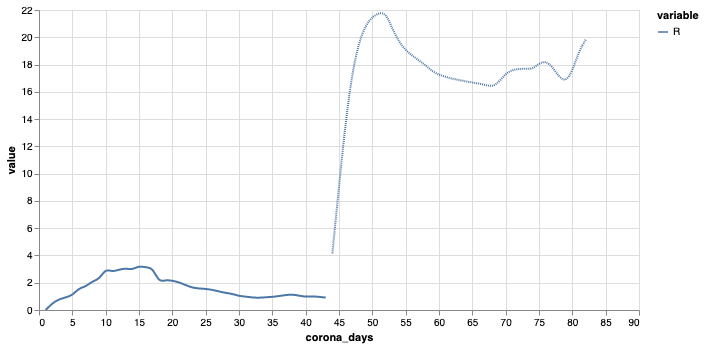

In [520]:
plot_data(df=olg_model.df, countries=p.countries, var_in_multi_line=['R'])

In [ ]:
plot_data(df=olg_model.df, countries=p.countries, var_in_multi_line='R')

In [ ]:
from scipy.io import loadmat
mat = loadmat(path +'sample.mat')
jh_hubei_data = mat.get('hubei')


In [ ]:
jh_hubei_list.T

jh_hubei_list.size


In [ ]:
jh_hubei_data 
 